In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
import argparse
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.feature_selection import RFECV
import mlflow
import shap
import json
import cupy
import anndata as ad
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from config import FDIR_EXTERNAL, FDIR_RAW, FDIR_PROCESSED, FDIR_INTEMEDIATE


from tqdm import tqdm



In [6]:

fdir_raw = FDIR_RAW
fdir_intermediate = FDIR_INTEMEDIATE
fdir_processed = FDIR_PROCESSED / 'sex'
fdir_external = FDIR_EXTERNAL
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'random_forest'

# Scaler = RobustScaler
Scaler = StandardScaler

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_featues_dict = {
    'CAGE.HEART': {
        'chr_aXY': 6,  # 10
        'chr_aX': 9,
        'chr_aY': 9,
        'autosomes': 20,
    }
}

filename_prefixes = {
    "None": "geuvadis",
    'CAGE.HEART': "CAGE.HEART"
}

organ_names = {
    'BRAIN0': "BRAIN0",
    "HEART": "HEART",
    "BRAIN1": "BRAIN1",
    'None': "BLOOD",
    'CAGE.HEART': 'CAGE.HEART'
}

value_to_predict = 'sex'

organ = "CAGE.HEART"

In [ ]:
# fig_cm, axs_cm = plt.subplots()
# cbar_ax1 = fig_cm.add_axes([.84, .25, .015, .6], in_layout=True)
# cbar_ax2 = fig_cm.add_axes([.92, .25, .015, .6], in_layout=True)

adata_raw = ad.read_h5ad(fdir_processed / f'{filename_prefixes[organ].upper()}.preprocessed.{value_to_predict}.h5ad')

# for sex_chromosome in ['autosomes']:
for sex_chromosome in ['autosomes', 'chr_aXY', 'chr_aX', 'chr_aY']:
    n_features = n_featues_dict[organ][sex_chromosome]
    
    n_features = n_featues_dict[organ][sex_chromosome]

    with open(f'../models/model_params.json', 'r') as file:
        model_params = json.load(file)[model_type]
    model_params = model_params[value_to_predict]
    # model_params['max_depth'] = 7

    adata = adata_raw[:, adata_raw.varm[sex_chromosome]].copy()
    
    features = pd.read_hdf(
        fdir_intermediate / f'feature_importance.{model_type}.{value_to_predict}.organ_{organ}.h5',
        key=f'{sex_chromosome}',
    )
    
    features_fname = f"{filename_prefixes[organ]}_train_features_{sex_chromosome}_calibration_{organ}.csv"
    features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, dtype=object)
    features_list.set_index('Feature', inplace=True)
    
    adata = adata[:, features_list.index]

    X = adata.X
    y = adata.obs[value_to_predict]

    label_encoder = LabelEncoder().fit(y)
    y = label_encoder.transform(y)
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=500)
    
    wrong_sex_cohort = np.zeros(X.shape[0], dtype=int)
    wrong_sex_total_number = np.zeros(X.shape[0], dtype=int)
    
    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        train_scaler = Scaler().fit(X_train)
        # test_scaler = Scaler().fit(X_test)
        
        X_train = train_scaler.transform(X_train)
        X_test = train_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test
        
        model = xgb.XGBClassifier(**model_params)
        model.fit(cupy.array(X_train_), y_train_, eval_set=[(X_val, y_val)], verbose=False)

        pred = model.predict(cupy.array(X_test))
        
        wrong_sex_cohort[val] += np.abs(pred-y_val)
        wrong_sex_total_number[val] += 1
        
        
    adata_raw.obs[f'wrong_sex_{sex_chromosome}'] = wrong_sex_cohort
    adata_raw.obs[f'wrong_sex_percent_{sex_chromosome}'] = wrong_sex_cohort/wrong_sex_total_number*100
    

855it [11:42,  1.22it/s]


KeyboardInterrupt: 

In [ ]:
adata_raw.obs

,dim1,dim2,chamber,side,chambers,disease,sex,batch,donor,ventricle_like_atrium_samples,age,wrong_sex_autosomes,wrong_sex_percent_autosomes,wrong_sex_chr_aXY,wrong_sex_percent_chr_aXY,wrong_sex_chr_aX,wrong_sex_percent_chr_aX,wrong_sex_chr_aY,wrong_sex_percent_chr_aY
S03_AA24845,2.510526,0.704468,LA,L,A,healthy,F,two,9_20_19,no,56.0,0,0.0,0,0.0,0,0.0,0,0.0
S04_AA25226,-1.092306,0.020104,LV,L,V,healthy,F,two,9_20_19,no,56.0,2,0.4,0,0.0,0,0.0,0,0.0
S05_AA23445,2.493484,0.611872,RA,R,A,healthy,F,two,9_20_19,no,56.0,0,0.0,0,0.0,0,0.0,0,0.0
S06_AA25184,-0.816983,-0.731661,RV,R,V,healthy,F,two,9_20_19,no,56.0,0,0.0,0,0.0,0,0.0,0,0.0
S09_AA24818,2.608582,0.411286,LA,L,A,healthy,F,two,10_3_19,no,71.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s91,2.161505,0.088385,RA,R,A,Ischemic CMY,M,three,A4B3; D1B3,no,44.0,0,0.0,0,0.0,3,0.6,0,0.0
s92,1.963207,0.470192,RA,R,A,Ischemic CMY,F,three,A4B3; D1B3,no,44.0,0,0.0,0,0.0,0,0.0,0,0.0
s93,-1.245986,0.896241,LV,L,V,Non-ischemic CMY,M,three,A4B1; D1B1,no,59.0,0,0.0,4,0.8,0,0.0,4,0.8
s94,-1.487166,1.082930,RV,R,V,Non-ischemic CMY,M,three,A4B1; D1B1,no,59.0,0,0.0,6,1.2,2,0.4,3,0.6


In [ ]:
# adata_raw.obs.to_csv('/home/ar3/Documents/PYTHON/RNASeqAnalysis/reports/Guys_with_wrong_sex_classificaion.csv')

In [ ]:
adata.obs['wrong_sex'] = wrong_sex_cohort
adata.obs['wrong_sex_percent'] = wrong_sex_cohort/wrong_sex_total_number*100

/tmp/ipykernel_301569/949140493.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['wrong_sex'] = wrong_sex_cohort


In [ ]:
adata[121].obs

,dim1,dim2,chamber,side,chambers,disease,sex,batch,donor,ventricle_like_atrium_samples,age,wrong_sex,wrong_sex_percent
s10_add,2.597468,-0.699243,RV,R,V,NICM,F,add,2011-04-16 00:00:00,no,NaN,495,99.0


In [ ]:
adata[121].var['seqnames']

09416    chr21
24729    chr20
10331     chr3
30589     chr9
18676    chr12
54614     chr2
10817     chr3
16695     chr1
04808    chr15
00842     chr1
23018    chr19
63929     chr4
22601    chr19
37204    chr10
11966     chr5
73336     chr9
20549    chr15
65907     chr5
63888     chr4
03502    chr12
Name: seqnames, dtype: category
Categories (12, object): ['chr1', 'chr2', 'chr3', 'chr4', ..., 'chr15', 'chr19', 'chr20', 'chr21']

In [ ]:
adata_raw = ad.read_h5ad(fdir_processed / f'CAGE.HEART.preprocessed.{value_to_predict}.h5ad')
adata_raw[121, adata_raw[121].var['seqnames'] == 'chrY']

View of AnnData object with n_obs × n_vars = 1 × 60
    obs: 'dim1', 'dim2', 'chamber', 'side', 'chambers', 'disease', 'sex', 'batch', 'donor', 'ventricle_like_atrium_samples', 'age'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'id', 'annotation', 'geneChr', 'geneStart', 'geneEnd', 'geneLength', 'geneStrand', 'geneId', 'distanceToTSS', 'class', 'seqname', 'transcript_id'
    varm: 'autosomes', 'chr_aX', 'chr_aXY', 'chr_aY', 'unique'
    layers: 'raw'

In [ ]:
adata_raw[-2, adata_raw.var[adata_raw[-2].var['seqnames'] == 'chrY'].index].X

ArrayView([[ 3.20660231,  3.04012725,  3.03671627,  4.26652001,
             3.03483626,  5.25712447,  5.25258963,  6.6378344 ,
             4.27510356,  6.64893905,  4.87383405,  9.03698717,
             5.99094554,  4.93758736,  6.39387162,  7.84473963,
             3.03693281,  3.43012519,  3.04410965,  5.51423752,
             3.79481748, 10.2371972 ,  3.27575356,  3.36395211,
             4.00223755,  2.9592132 ,  2.93383983,  3.24708399,
             3.17840558,  3.44814112,  4.23864902,  2.98294076,
             3.8082784 ,  4.60499218,  3.79632705,  5.62144388,
             3.86490916,  3.58996583,  3.49683623,  3.82329598,
             3.49210198,  3.09607695,  3.09854404,  3.80167015,
             4.57846798,  3.32137471,  3.08691261,  4.16275642,
             4.39908349,  3.01235929,  3.20835792,  3.67926239,
             3.19212227,  3.01493065,  3.01134975,  3.67130233,
             3.11130174,  3.02695761,  3.08228117,  3.23387641]])

In [ ]:
adata_raw[-2].obs

,dim1,dim2,chamber,side,chambers,disease,sex,batch,donor,ventricle_like_atrium_samples,age
s94,-1.487166,1.08293,RV,R,V,Non-ischemic CMY,M,three,A4B1; D1B1,no,59.0


<Axes: ylabel='Count'>

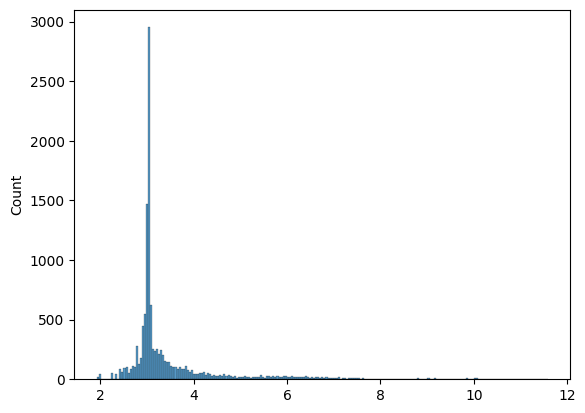

In [10]:
sns.histplot(adata_raw[:, adata_raw.var['seqnames'] == 'chrY'].X.ravel())

In [8]:
data_to_show = adata_raw[:, adata_raw.var['seqnames'] == 'chrY'].to_df()
data_to_show['sex'] = (adata_raw.obs['sex'] == 'M')*10
data_to_show

,15572,15573,15574,15575,15576,15577,15578,15579,15580,15581,...,75254,75255,75256,75257,75258,75259,75260,75261,75262,sex
S03_AA24845,3.051215,3.050236,3.043061,2.881590,3.050828,2.687047,2.768952,2.547374,2.987214,2.438668,...,2.995156,3.025270,2.974311,3.021743,2.961187,3.015111,3.071928,2.966056,2.931755,0
S04_AA25226,3.051215,3.050236,3.043061,2.881590,3.050828,2.687047,2.768952,2.547374,2.987214,2.593138,...,2.995156,3.025270,2.974311,3.021743,2.961187,3.015111,3.071928,2.966056,2.931755,0
S05_AA23445,3.051215,3.050236,3.043061,2.881590,3.050828,2.687047,2.768952,2.547374,2.987214,2.438668,...,2.995156,3.025270,2.974311,3.021743,2.961187,3.015111,3.071928,2.966056,2.931755,0
S06_AA25184,3.051215,3.050236,3.043061,2.881590,3.050828,2.687047,2.768952,2.547374,2.987214,2.710178,...,2.995156,3.025270,2.974311,3.021743,2.961187,3.015111,3.071928,2.966056,2.931755,0
S09_AA24818,3.051215,3.050236,3.043061,2.881590,3.050828,2.687047,2.768952,2.547374,2.987214,2.438668,...,2.995156,3.025270,2.974311,3.021743,2.961187,3.015111,3.071928,2.966056,2.931755,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s91,3.041751,3.040127,3.806649,3.396883,3.034836,5.692687,6.353186,7.454249,4.684953,7.058433,...,3.530557,3.027485,3.014931,3.245070,3.601450,3.288780,3.462333,4.084681,3.789682,10
s92,3.041751,3.040127,3.036716,2.796971,3.034836,3.087045,2.519329,3.075466,2.633987,3.105426,...,3.033597,3.027485,3.014931,3.011350,2.991185,3.054166,3.026958,3.082281,3.150856,0
s93,3.041751,3.309529,3.036716,4.119296,3.175748,5.876982,5.391031,6.707984,4.175838,7.070689,...,3.033597,3.891607,3.086970,3.151955,3.485504,3.441942,3.026958,3.082281,3.068627,10
s94,3.206602,3.040127,3.036716,4.266520,3.034836,5.257124,5.252590,6.637834,4.275104,6.648939,...,3.679262,3.192122,3.014931,3.011350,3.671302,3.111302,3.026958,3.082281,3.233876,10


In [39]:
mean_expression = data_to_show.mean(axis=1)

data_female = data_to_show.loc[data_to_show['sex'] == 0]
data_male = data_to_show.loc[data_to_show['sex'] > 1]

mean_data_female = data_female.mean(axis=1)
mean_data_male = data_male.mean(axis=1)

data_female = data_female.loc[mean_data_female.sort_values().index[::-1]]
data_male =data_male.loc[mean_data_male.sort_values().index[::-1]]


<Axes: >

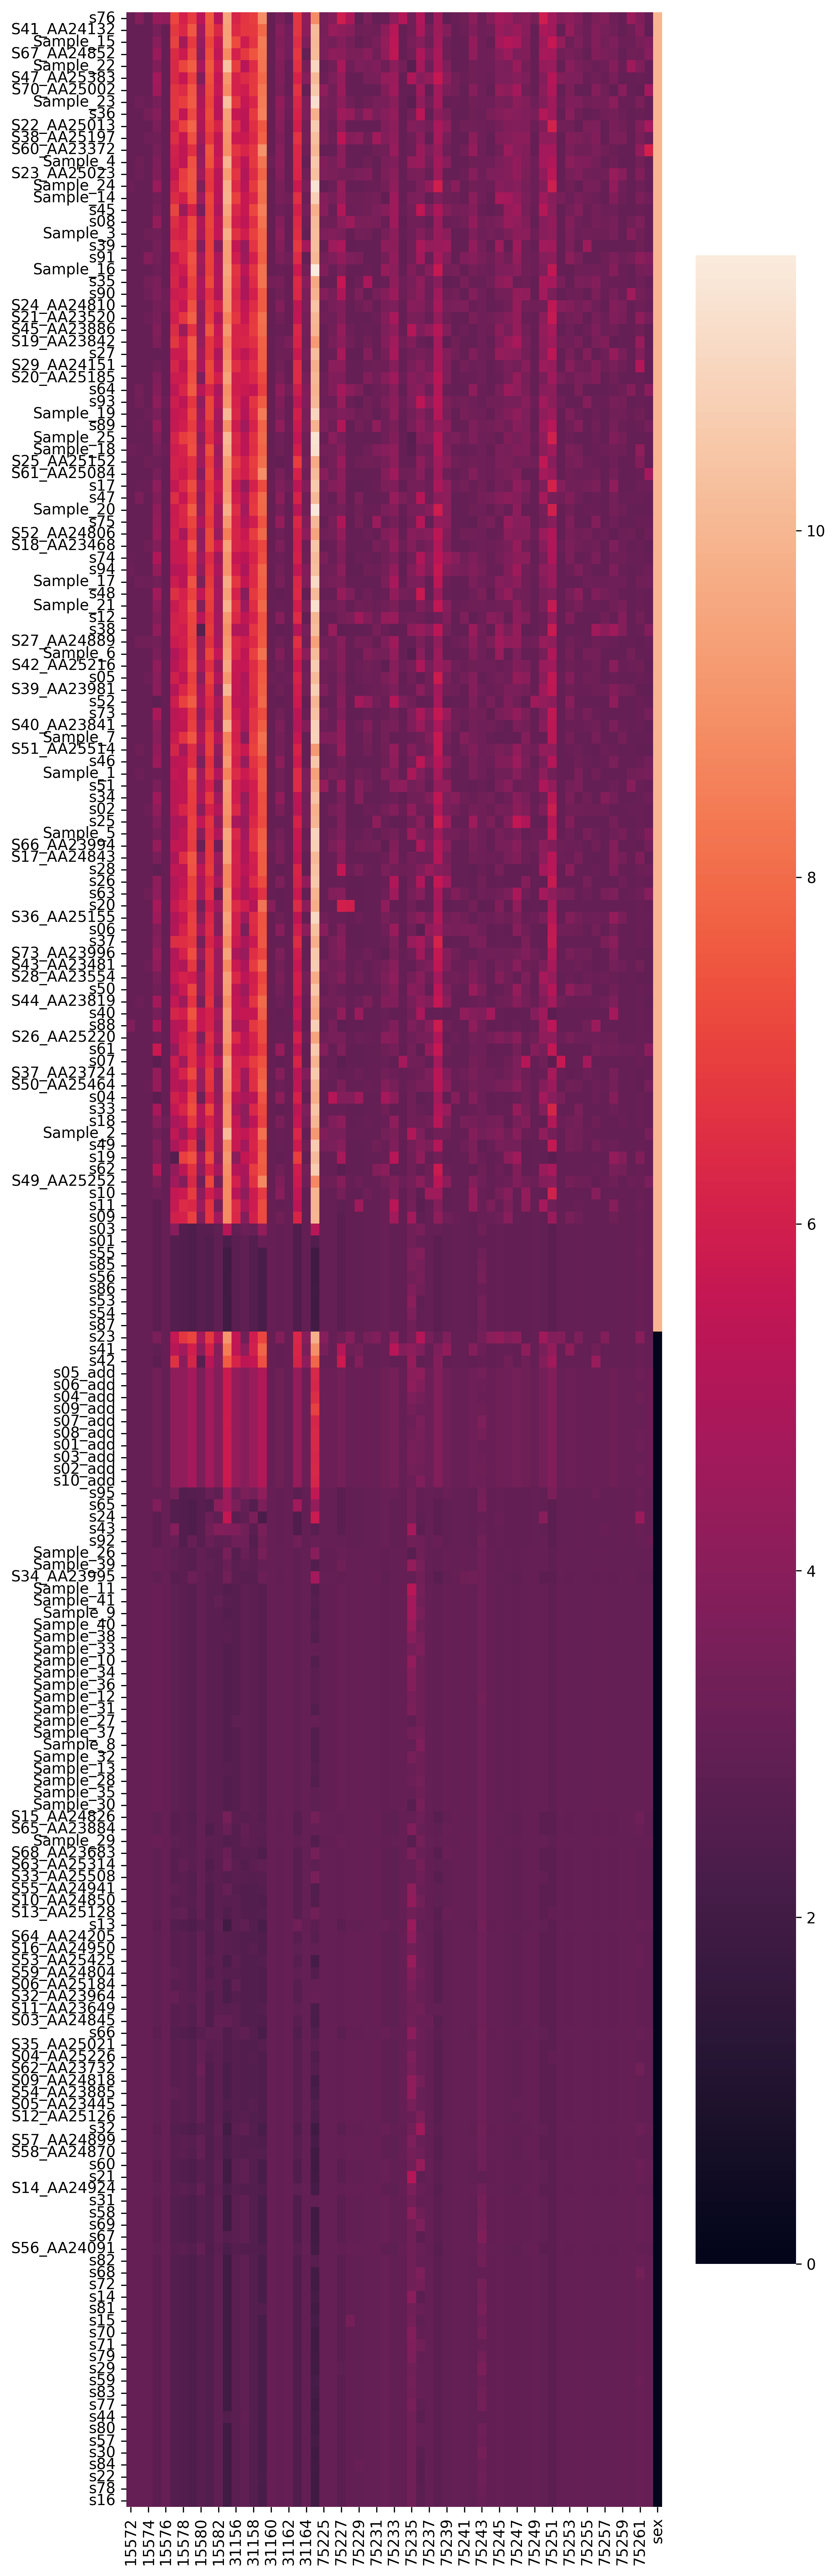

In [41]:
plt.figure(figsize=(8,30), dpi=300)
sns.heatmap(pd.concat([data_male, data_female]), yticklabels=pd.concat([data_male, data_female]).index)

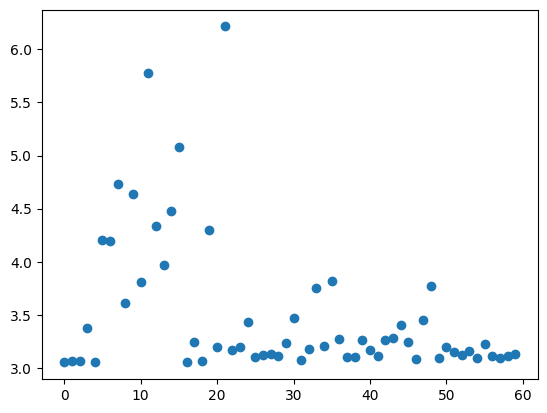

In [11]:
plt.plot(adata_raw[121, adata_raw.var['seqnames'] == 'chrY'].X[0], 'o' )

In [12]:
sns.heatmap(adata_raw.obs['sex'].values.reshape(1, -1))

ValueError: could not convert string to float: 'F'